# About This Notebook

This notebook focuses on training a machine learning model to classify 200 different species of birds, the machine learning model uses pre-trained EfficientNetB0 model with custom layers on top to learn and cliassify the images.

# Motive behind this notebook

The resultant model from this model can have many applications to solve real life problems. It can be used in wild life cameras that are placed sometimes placed around forests or wild life sanctuaries to keep a close tabs on different birds species. It can also be used as an extension to a application or chatbot which will hwlp users to identify the species of bird when needed, and the list goes on.

# Importing necessary libraries 

In [1]:
import tensorflow as tf
import os
import numpy as np
import requests
from io import BytesIO
import statistics
import random
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0

# Saving paths to be used

First we will save the file-paths which we will be using in this notebook

In [2]:
main_path = r'E:\birds_classificationAI\data'

In [3]:
import os
train = os.path.join(main_path,'train')
test = os.path.join(main_path,'test')
valid = os.path.join(main_path,'valid')

# visulalize the images

Now we will visualize a image at random with its label name to identify how our image looks

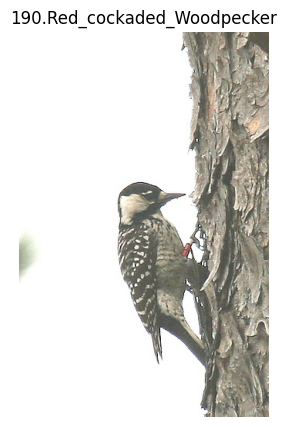

In [4]:
import matplotlib.pyplot as plt
# if running this code section mutiple times below code will clear the previous output
fig = plt.gcf()

# setting size of image plot
fig.set_size_inches(5,5)

# choosing a image at random
species = random.choice(os.listdir(train))
img_choice = random.choice(os.listdir(os.path.join(train,species)))
img_path = os.path.join(train,species,img_choice)

# reading and printing the image
img = mimg.imread(img_path)
plt.title(species)
plt.axis('off')
plt.imshow(img)

# Checking distribution of images in each class

Now we will check the distributuon of images across different classes, it is necessary because if images are not distributed evenly across the classes, there might be chances that our model can underfit or overfit on the data.

In [5]:
store_species_count ={}
list_species = os.listdir(os.path.join(main_path,train))

for each in list_species:
    count_imgs = len(os.listdir(os.path.join(main_path,train,each)))
    store_species_count[each] = count_imgs

# Find the minimum value and its key
min_key, min_value = min(store_species_count.items(), key=lambda x: x[1])

# Find the maximum value and its key
max_key, max_value = max(store_species_count.items(), key=lambda x: x[1])

# Get a list of the dictionary values
values_list = list(store_species_count.values())

# Compute the median value
median_value = statistics.median(values_list)

print("Minimum count of images in a class:", min_value, "corresponding Species:", min_key)
print("Maximum count of images in a class:", max_value, "corresponding Species:", max_key)
print("Median value:", median_value, "images")

Minimum count of images in a class: 17 corresponding Species: 107.Common_Raven
Maximum count of images in a class: 29 corresponding Species: 021.Eastern_Towhee
Median value: 26.0 images


# Categorizing the images

Here we are using Tensorflows ImageDataGenerator function this function takes image directory path. preprocess the image and stratify the count of images in each class such that each class has same number of images for model training.

In [6]:
# preprocessing the image and storing it under appropriate labels

train_gen = ImageDataGenerator(width_shift_range = 0.5,
                              height_shift_range = 0.5)

train_set = train_gen.flow_from_directory(train,target_size = (224,224),class_mode = 'categorical',batch_size = 32)

Found 5089 images belonging to 200 classes.


In [7]:
# geting the labels from training data, it will be later used to predict the class when an image is passed

labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
len(labels)

200

Below we see that we are not preprocessing test and validation data, its because we will be using this images to see how well our model predicts.

In [8]:
# Getting data for testing
test_gen = ImageDataGenerator()

test_set = test_gen.flow_from_directory(test,target_size = (224,224),class_mode = 'categorical',batch_size = 32)

Found 5794 images belonging to 200 classes.


In [9]:
# getting data for validation
valid_gen = ImageDataGenerator()

valid_set = valid_gen.flow_from_directory(valid,target_size = (224,224),class_mode = 'categorical',batch_size = 32)

Found 905 images belonging to 200 classes.


# Creating our model

Now we are ready with our data lets start building our image classifier model, for that first we need to get EfficientNetB0 model from Tensorfow Keras API, more about EfficientNetB0 can be found here https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

Below we can also see that we are setting the layers of our EfficientNetB0 to **False**, its because this model has already been trained on larger set of image data and we are using it classify our birds species, also if we want we can set layers to true, but it will consume more time in training our model.

In [10]:
# Downloading the pre-trained model from API
eff_net_model = EfficientNetB0(
                    include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='max',
                    classes=len(labels)
                )

# setting all the layers of this model to false
for layer in eff_net_model.layers:
    layer.trainable = False

After we download EfficientNetB0, We are adding custom dense layers to the model so that our model can classify images based on 525 diffent labels.

In [11]:
model = Sequential()
model.add(eff_net_model)
model.add(Dense(2560,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1280,activation='relu'))
model.add(Dense(len(labels),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 2560)              3279360   
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1280)              3278080   
                                                                 
 dense_2 (Dense)             (None, 200)               256200    
                                                                 
Total params: 10873451 (41.48 MB)
Trainable params: 6818

Now we will its time to select our optimizer for our model, Adam Optimizer is the best optimizer for our use case as it has better optimization and faster compuation time, we can also set learnign rate for our optimizer, I have used 0.00001 as my learning_rate value, this is the best learning rate value for our use-case.

In [12]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001) ,loss = 'categorical_crossentropy',metrics = 'accuracy')

In [13]:
#Using tensorflow's EarlyStopping , this is used to stop training of model if there is no improvment of loss over each epoch
early = tf.keras.callbacks.EarlyStopping(patience = 5)

# Using tensorflow's Model-Checkpoint to save best model having lower validation loss
modelcheck_lr = tf.keras.callbacks.ModelCheckpoint(filepath='final_model.h5',monitor='val_loss',save_best_only = True,save_format='tf')

# Training the Model

Now we have built our model and specified required optimizer and callbacks, its time to train our model and visualize the training results

In [14]:
import time

# Before training
start_time = time.time()
model_hist = model.fit(train_set,validation_data = valid_set,epochs =50,callbacks = [modelcheck_lr,early])
# After training
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time/60:.2f} minutes")

# Evaluate accuracy on validation set
loss, acc = model.evaluate(valid_set, verbose=0)
print(f"Validation accuracy: {acc*100:.2f}%")


Epoch 1/50
160/160 [==============================] - ETA: 0s - loss: 5.4985 - accuracy: 0.0136

e:\birds_classificationAI\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 408s 2s/step - loss: 5.4985 - accuracy: 0.0136 - val_loss: 5.0681 - val_accuracy: 0.0398
Epoch 2/50
160/160 [==============================] - 280s 2s/step - loss: 4.8025 - accuracy: 0.0629 - val_loss: 4.3900 - val_accuracy: 0.1326
Epoch 3/50
160/160 [==============================] - 286s 2s/step - loss: 4.2756 - accuracy: 0.1436 - val_loss: 3.8626 - val_accuracy: 0.2254
Epoch 4/50
160/160 [==============================] - 286s 2s/step - loss: 3.8095 - accuracy: 0.2279 - val_loss: 3.4394 - val_accuracy: 0.2895
Epoch 5/50
160/160 [==============================] - 284s 2s/step - loss: 3.4780 - accuracy: 0.2869 - val_loss: 3.1034 - val_accuracy: 0.3536
Epoch 6/50
160/160 [==============================] - 286s 2s/step - loss: 3.1660 - accuracy: 0.3396 - val_loss: 2.8129 - val_accuracy: 0.4000
Epoch 7/50
160/160 [==============================] - 287s 2s/step - loss: 2.9402 - accuracy: 0.3846 - val_loss: 2.5871 - val_accuracy: 0.4354
Epoch 8/50

In [16]:

 #Visualizing the result 
acc = model_hist.history['accuracy']
val_acc = model_hist.history['val_accuracy']
loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']

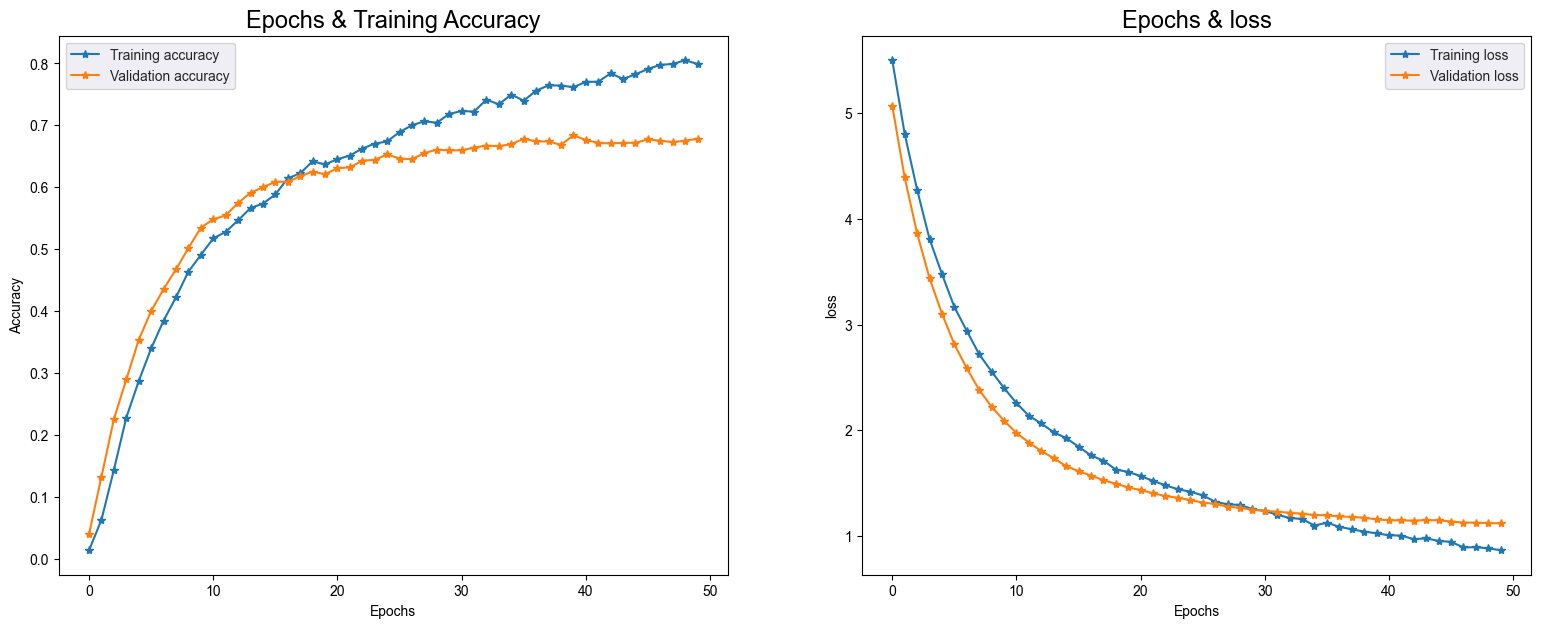

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, '*-',label = 'Training accuracy')
ax[0].plot(val_acc, '*-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, '*-',label = 'Training loss')
ax[1].plot(val_loss, '*-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

# Evaluate Performance of model

Now we have trained the model lets evaluate performance of our model on image data it has not viewed before

In [18]:
# load and evaluate best model
model.load_weights(r"E:\birds_classificationAI\final_model.h5")
eval_data = model.evaluate(test_set)
print("Validation Loss :",eval_data[0])
print("Validation Accuracy :",eval_data[1])

182/182 [==============================] - 233s 1s/step - loss: 1.1235 - accuracy: 0.6955
Validation Loss : 1.1234768629074097
Validation Accuracy : 0.6955471038818359


Now we have seen accuracy and loss of our model using validation set, lets see visually how our model, by picking images at random from validation set.
Below I have created a funtion called "predict_pipeline", this will take image path (already stored in local) from user and predict the output label of the image accordingly

In [19]:
def predict_pipeline(image_path):
    # Define the input image size
    input_shape = (224, 224)
            
    # load image data
    img = load_img(image_path, target_size=input_shape)
            
    # convert image to array
    x = img_to_array(img)
            
    # preprocess the image using efficientnet preprocessor
    x = preprocess_input(x)

    # Make the prediction
    preds = model.predict(np.array([x]))

    # get the index of the predicted class
    index = np.argmax(preds)
    
    # get the predicted class name
    predicted_class = labels[index]

    # Return prediced_class
    return predicted_class

1/1 [==============================] - 0s 71ms/step


<Figure size 640x480 with 0 Axes>

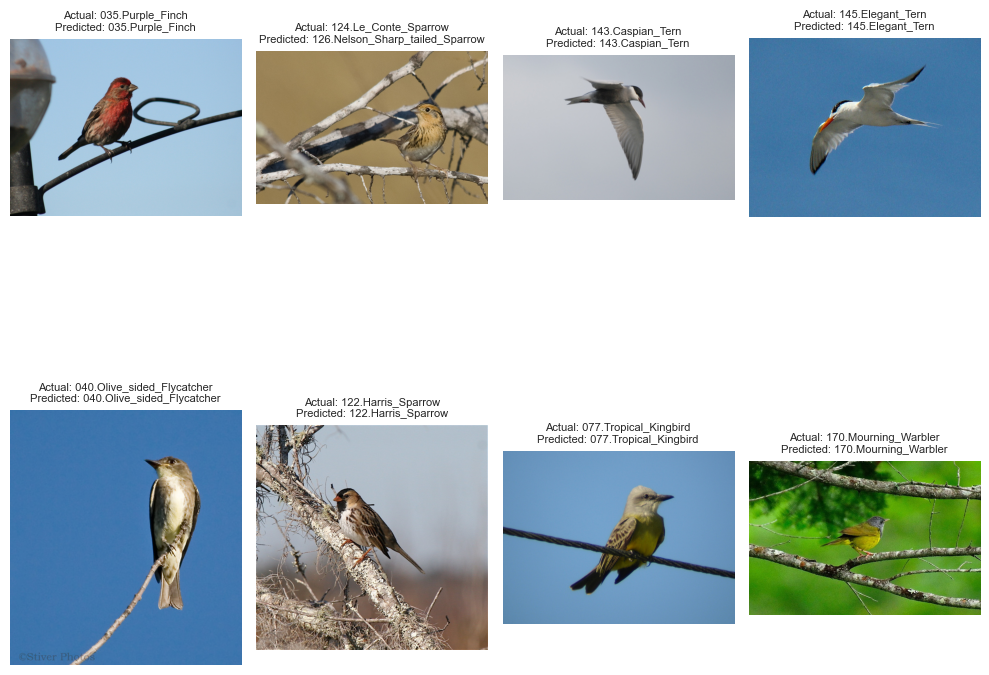

In [20]:
n_rows = 2
n_cols = 4
# Here we are using gcf to clen the plot if the cell is being runned 2 or more times
fig = plt.gcf()

# Create a figure and subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

# set size of each image
fig.set_size_inches(10, 10)

species = []
img_path = {}

# choosing a image at random
for i in range(n_rows*n_cols):
    species.append(random.choice(os.listdir(valid)))

for bird in species:
    img_choice = random.choice(os.listdir(os.path.join(train,bird)))
    full_path = os.path.join(train,bird,img_choice)
    img_path[bird] = full_path

# reading and printing the image
i = 0
for key in img_path.keys():
    sp = plt.subplot(n_rows, n_cols, i + 1)
    img = mimg.imread(img_path[key])
    predicted = predict_pipeline(img_path[key])
    sp.set_title('Actual: '+str(key)+'\n'+'Predicted: '+str(predicted), fontsize=8)
    sp.axis('off')
    plt.imshow(img)
    i += 1

plt.tight_layout()


# Testing model in real-world situation

Now we are ready with our model, now lets test a situation where user sends url of the image and our model predicts the species of the bird.

Below I defined 2 funtions

1) predict_pipeline_url : This will take URL from user and predict the species of the bird

2) predict_bird_from_URL: This will take URL from user print the image and also its label using the "predict_pipeline_url" funtion

In [22]:
def predict_pipeline_url(image_url):
    # get the image from the url
    response = requests.get(image_url)

    # Define the input image size
    input_shape = (224, 224)
            
    # load image data
    img = load_img(BytesIO(response.content), target_size=input_shape)
            
    # convert image to array
    x = img_to_array(img)
            
    # preprocess the image using efficientnet preprocessor
    x = preprocess_input(x)

    # Make the prediction
    preds = model.predict(np.array([x]))

    # get the index of the predicted class
    index = np.argmax(preds)
 
    # get the predicted class name
    predicted_class = labels[index]
    
    return predicted_class
    

In [24]:
def predict_bird_from_URL(image_url):
    # Here we are using gcf to clean the plot if the cell is being runned 2 or more times
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    
    # get and store the response from URL
    response = requests.get(image_url)
    
    # read the image
    img = mimg.imread(BytesIO(response.content), format='jpg')
    
    # predict the image from URL
    predicted = predict_pipeline_url(image_url)
    
    # pint the image along with predicted label
    plt.title('Predicted: '+str(predicted), fontsize=10)
    plt.axis('off')
    plt.imshow(img)


Model loaded successfully!
1/1 [==============================] - 2s 2s/step


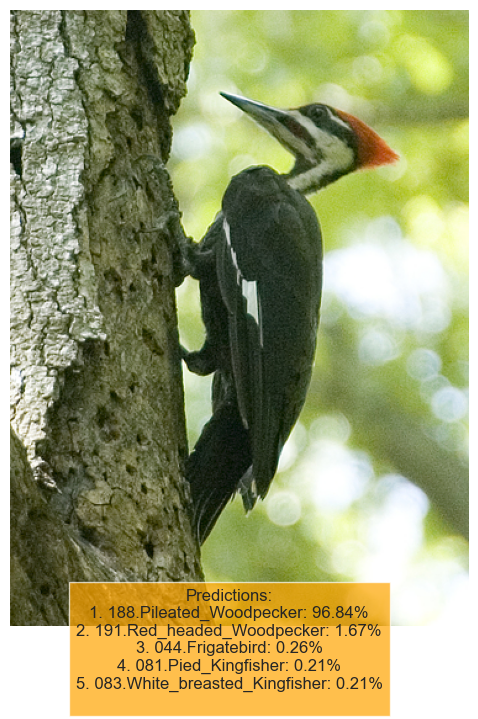


Top Predictions:
1. 188.Pileated_Woodpecker: 96.84%
2. 191.Red_headed_Woodpecker: 1.67%
3. 044.Frigatebird: 0.26%
4. 081.Pied_Kingfisher: 0.21%
5. 083.White_breasted_Kingfisher: 0.21%


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
import os

# Load the trained model (assuming it's saved as 'bird_species_model.h5')
def load_model(model_path):
    """
    Load the pre-trained bird species classification model
    """
    try:
        model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Preprocess the image for EfficientNet
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Load and preprocess an image for prediction
    """
    try:
        # Load image
        img = image.load_img(img_path, target_size=target_size)
        # Convert to array
        img_array = image.img_to_array(img)
        # Expand dimensions to create a batch
        img_array = np.expand_dims(img_array, axis=0)
        # Preprocess for EfficientNet
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Get class names (assuming they're saved in a text file)
def get_class_names(class_names_path):
    """
    Load class names from a text file
    """
    try:
        with open(class_names_path, 'r') as f:
            class_names = [line.strip() for line in f.readlines()]
        return class_names
    except Exception as e:
        print(f"Error loading class names: {e}")
        return None

# Make prediction on an image
def predict_bird_species(model, img_array, class_names, top_k=5):
    """
    Make prediction and return top k results
    """
    predictions = model.predict(img_array)
    # Get top k predictions
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_k_probs = predictions[0][top_k_indices]
   
    results = []
    for i in range(top_k):
        results.append({
            'species': class_names[top_k_indices[i]],
            'confidence': float(top_k_probs[i])
        })
   
    return results

# Display image and prediction results
def display_results(img_path, results):
    """
    Display the image and prediction results
    """
    img = image.load_img(img_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
   
    # Create prediction text
    prediction_text = "Predictions:\n"
    for i, result in enumerate(results):
        prediction_text += f"{i+1}. {result['species']}: {result['confidence']*100:.2f}%\n"
   
    plt.figtext(0.5, 0.01, prediction_text, ha="center", fontsize=12,
                bbox={"facecolor":"orange", "alpha":0.7, "pad":5})
    plt.show()

# Main function
def main():
    # Paths (update these with your actual paths)
    model_path = 'models/best_model.h5'  # Path to your trained model
    class_names_path = 'classes.txt'  # Path to text file with class names
    image_path = r"E:\birds_classificationAI\src\data\CUB_200_2011\images\188.Pileated_Woodpecker\Pileated_Woodpecker_0004_180307.jpg" # Path to the image you want to classify
   
    # Load model
    model = load_model(model_path)
    if model is None:
        return
   
    # Load class names
    class_names = get_class_names(class_names_path)
    if class_names is None:
        return
   
    # Preprocess image
    img_array = preprocess_image(image_path)
    if img_array is None:
        return
   
    # Make prediction
    results = predict_bird_species(model, img_array, class_names)
   
    # Display results
    display_results(image_path, results)
   
    # Print results to console as well
    print("\nTop Predictions:")
    for i, result in enumerate(results):
        print(f"{i+1}. {result['species']}: {result['confidence']*100:.2f}%")

if __name__ == "__main__":
    main()

## Sample 1

1/1 [==============================] - 0s 84ms/step


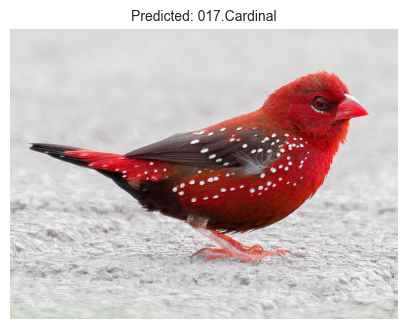

In [33]:
predict_bird_from_URL('https://cdn.download.ams.birds.cornell.edu/api/v1/asset/78541101/1200')

## Sample 2

1/1 [==============================] - 0s 75ms/step


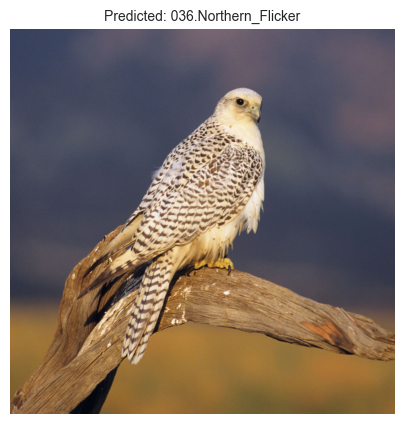

In [36]:
predict_bird_from_URL('https://cdn.britannica.com/22/137322-050-EC0B557E/Gyrfalcon.jpg')